# Loading libraries

In [1]:
# Libraries

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz
import pydotplus

# model creation and metrics
from tensorflow import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

# other
import os
from PIL import Image
import random
from collections import Counter


# EDA

In [2]:
# Loading attached .csv's to get basic info about dataset

#Train.csv contains information regarding each train image
df_train = pd.read_csv("https://raw.githubusercontent.com/imarekkus/Master-s_Thesis/main/dane/GTSRB/Train.csv")
#labels_train = df_train['ClassId']

#Test.csv contains information regarding each test image
df_test = pd.read_csv('https://raw.githubusercontent.com/imarekkus/Master-s_Thesis/main/dane/GTSRB/Test.csv')
#labels_test = df_test['ClassId']


df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Basic info about the image shape, test and training set
print("Training Set: {} samples".format(len(df_train)))
print("Test Set:     {} samples".format(len(df_test)))

Training Set: 39209 samples
Test Set:     12630 samples


In [5]:
# Unique classes
len(np.unique(df_train['ClassId']))

43

In [3]:
# Defining function to load training dataset

def readGTSRBTrain(rootpath):

    '''Function for reading GTSRB Train dataset
    Argument: path to the traffic sign data, i.e. './GTSRB/Train'
    Returns:   list of images, list of corresponding labels'''

    images = [] # images
    labels = [] # corresponding labels
    
    # loop over all 42 classes
    for imgclass in range(0,43):

        # get path to folder for each class
        path = rootpath + '/' + str(imgclass)

        # get the list of images in the specified folder
        images_list = os.listdir(path)

        # iterate over the list of images
        for i in images_list:
            

            try:
                
                # open each image in the list
                image = Image.open(path + '/' + i)

                # resize each image to the same size
                image = image.resize((32,32))

                # convert it into numpy array
                image = np.array(image)

                #append images and labels
                images.append(image)
                labels.append(imgclass)

            except:

                # print error and which image it concerns
                print("ERROR loading image " + str(i))

    return images, labels


In [4]:
# Reading GTSRB train dataset

trainImages, trainLabels = readGTSRBTrain('E:/Praca Magisterska/GTSRB/Train')


In [5]:
# Reading GTSRB test dataset

def readGTSRBTest():

    '''Function for reading GTSRB Test dataset
    Arguments: none
    Returns:   list of images'''

    # reading Test.csv to get paths to test images
    df_test = pd.read_csv('https://raw.githubusercontent.com/imarekkus/Master-s_Thesis/main/dane/GTSRB/Test.csv')

    path = df_test["Path"].values
    labels = df_test["ClassId"].values
    

    testImages=[]
    #testLabels=[]

    # iterate over the list of images path from csv
    for img in path:

        try: 
            # open each image in the folder
            image = Image.open('E:/Praca Magisterska/GTSRB/'+ img)
            
            # resize each image to the same size
            image = image.resize([32, 32])

            # convert it into numpy array
            image = np.array(image)

            #append images 
            testImages.append(image)

        except:
            print("ERROR loading image " + str(img))

    return testImages, labels


In [6]:
# Reading GTSRB test dataset

testImages, testLabels = readGTSRBTest()

In [7]:
# Checking size of both lists
print("Images and labels in train data: ")
print(len(trainLabels), len(trainImages))
print("Images in test data: ")
print(len(testLabels), len(testImages))

Images and labels in train data: 
39209 39209
Images in test data: 
12630 12630


In [8]:
# Size of images

# Combine two columns into new one called size
df_train['Size'] = df_train['Width'].astype(str) + 'x' + df_train['Height'].astype(str)
df_test['Size'] = df_test['Width'].astype(str) + 'x' + df_test['Height'].astype(str)

# Getting unique values
len(np.unique(df_train['Size']))

2924

(32, 32, 3)


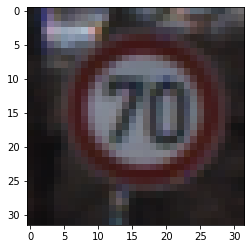

In [12]:
# Example of train image
print(trainImages[8000].shape)
plt.imshow(trainImages[8000])
plt.show()


In [13]:
# Creating table with summary of basic info
df_summary = pd.DataFrame({'Liczebność danych':['Zbiór treningowy', 'Zbiór testowy', 'Liczba klas'],
                                'Wartości':[len(trainImages), len(testImages), len(np.unique(df_train['ClassId']))]
                                })
df_summary

,Liczebność danych,Wartości
0,Zbiór treningowy,39209
1,Zbiór testowy,12630
2,Liczba klas,43


In [14]:
# Saving table to csv
#df_summary.to_csv('Podsumowanie danych.csv', encoding='utf-8-sig', index=False)

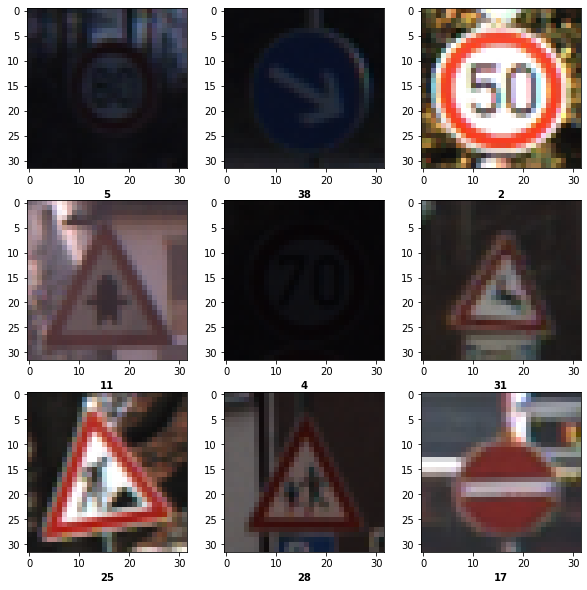

In [15]:
# Visualizing some more images

# Setting size of figure
plt.figure(figsize=(10,10))

# Setting up seed for replicability
random.seed(1)

# Loop for creating figure with images
for i in range(1,10):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Choosing random number
    number = random.randint(0,39209)

    # Getting random image and coresponding label
    image = trainImages[number]
    label = trainLabels[number]

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel(label, fontweight='bold')

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

In [9]:
# Balance of classes
unique_classes_train, classes_counts_train = np.unique(df_train['ClassId'], return_counts=True)

unique_classes_test, classes_counts_test = np.unique(df_test['ClassId'], return_counts=True)

In [10]:
# Corresponding labels
classes_train = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [18]:
# Looking at the mean number of images of classes
print("Train set mean: {:.0f}".format(classes_counts_train.mean()))
print("Train set mean: {:.0f}".format(classes_counts_test.mean()))


Train set mean: 912
Train set mean: 294


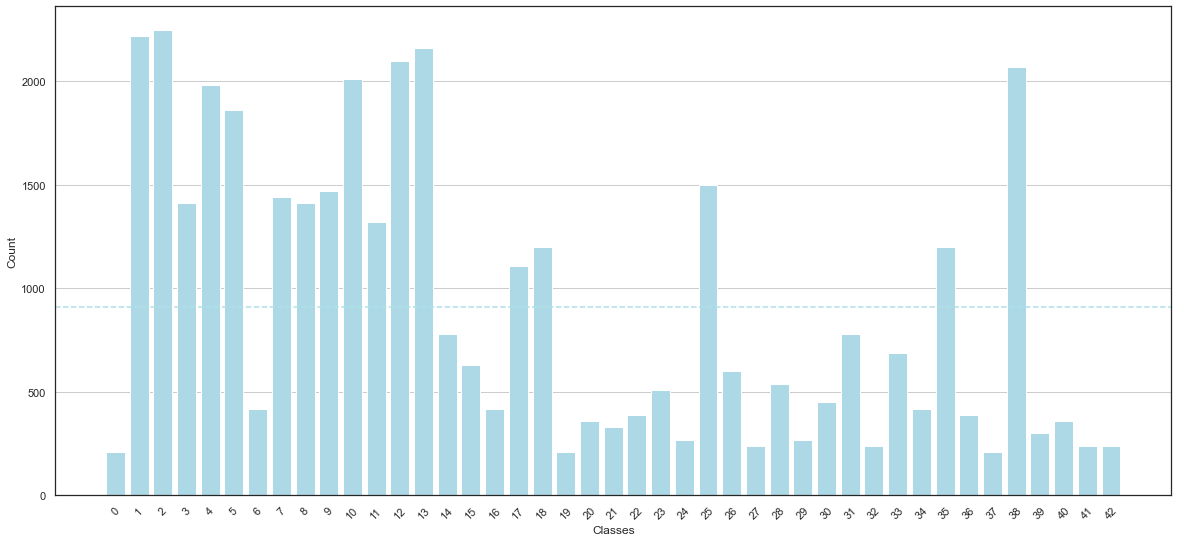

In [19]:
# Balance of classes in train set

# Setting up theme and grid look
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(20,9))
plt.grid(axis='y')

# Plotting barplot, rotating ticks and adding mean
plt.bar(unique_classes_train, classes_counts_train, color='lightblue')
plt.xticks(unique_classes_train, rotation=45)
plt.axhline(y = classes_counts_train.mean(), linestyle='--', color='powderblue')

# Adding labels
plt.xlabel('Classes')
plt.ylabel('Count')

plt.show()

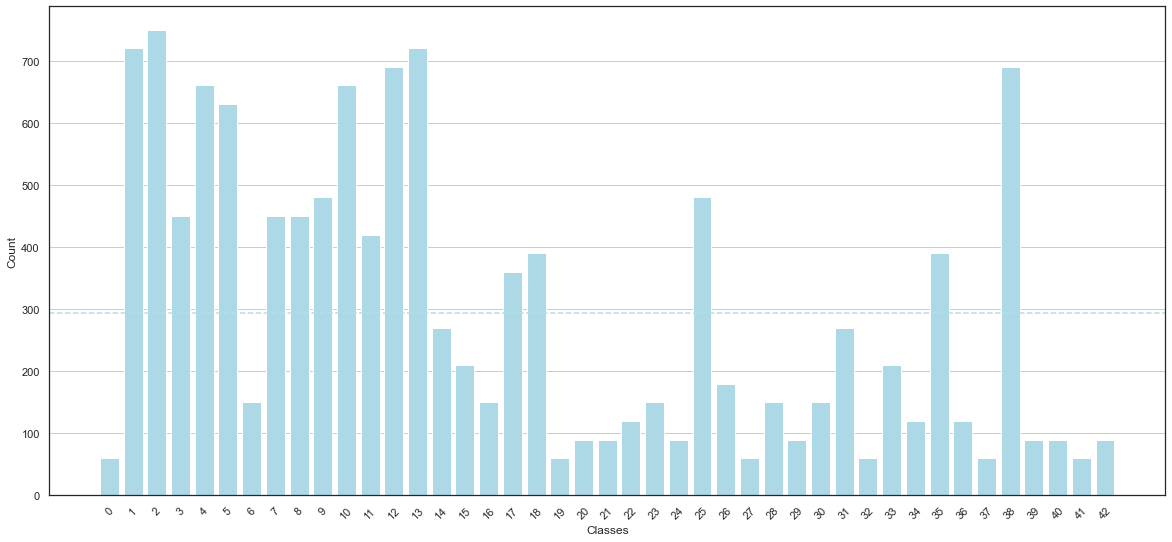

In [20]:
# Balance of classes in test set

# Setting up theme and grid look
plt.figure(figsize=(20,9))
plt.grid(axis='y')

# Plotting barplot, rotating ticks and adding mean
plt.bar(unique_classes_test, classes_counts_test, color='lightblue')
plt.xticks(unique_classes_test, rotation=45)
plt.axhline(y = classes_counts_test.mean(), linestyle='--', color='powderblue')

# Adding labels
plt.xlabel('Classes')
plt.ylabel('Count')

plt.show()

In [15]:
# Different size of images

# For train set
unique_height_train, height_counts_train = np.unique(df_train['Height'], return_counts=True)
unique_width_train, width_counts_train = np.unique(df_train['Width'], return_counts=True)

# and for test set
unique_height_test, height_counts_test = np.unique(df_test['Height'], return_counts=True)
unique_width_test, width_counts_test = np.unique(df_test['Width'], return_counts=True)


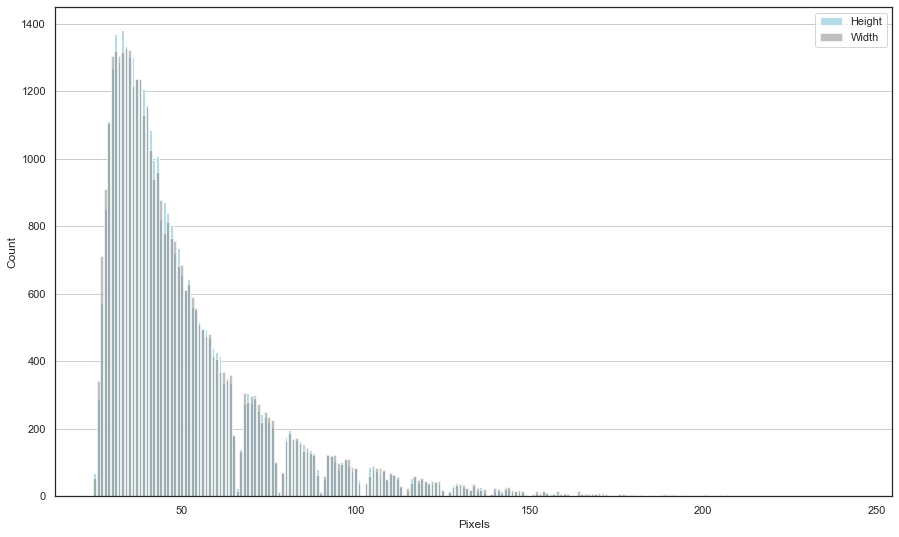

In [22]:
# Different size of images in train set

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting barplot 
plt.bar(unique_height_train, height_counts_train, color='lightblue', alpha=0.9, label='Height')
plt.bar(unique_width_train, width_counts_train, color='grey', alpha=0.5, label='Width')

# and adding mean
#plt.axhline(y = height_counts_train.mean(), linestyle='--', color='powderblue')
#plt.axhline(y = width_counts_train.mean(), linestyle='--', color='grey')

# adding labels and legend
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend(loc='upper right')

plt.show()

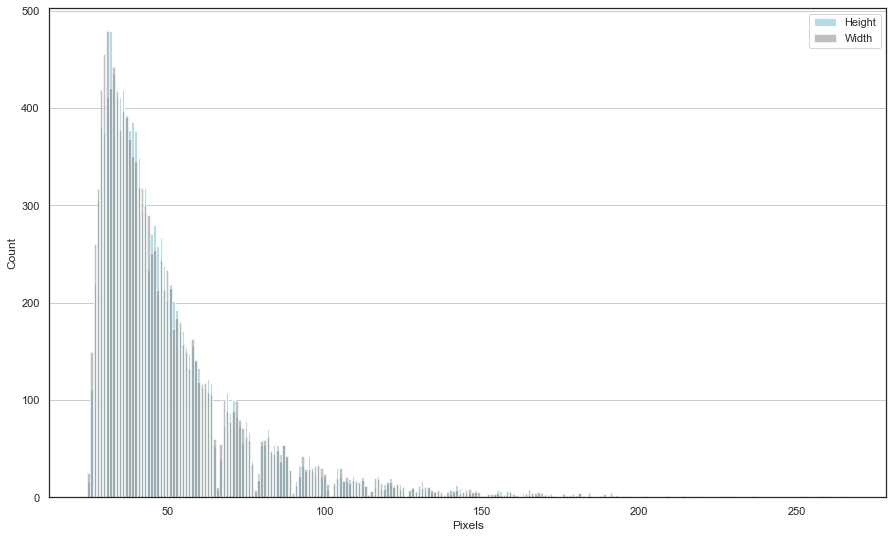

In [23]:
# Different size of images in test set

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting barplot 
plt.bar(unique_height_test, height_counts_test, color='lightblue', alpha=0.9, label='Height')
plt.bar(unique_width_test, width_counts_test, color='grey', alpha=0.5, label='Width')

# and adding mean
#plt.axhline(y = unique_height_test.mean(), linestyle='--', color='powderblue')
#plt.axhline(y = width_counts_test.mean(), linestyle='--', color='grey')

# adding labels and legend
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Creating additional validation set to see if overfitting problem exists

# Splitting training and testing dataset
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Preparing data

In [11]:
# Converting data into numpy arrays
X_train = np.array(trainImages)
y_train = np.array(trainLabels)

X_test = np.array(testImages)
y_test = np.array(testLabels)

In [12]:
X_train[8000].shape

(32, 32, 3)

In [13]:
# One hot encoding for labels
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Model without augmentations

### First model

In [132]:
# First model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 6, 6, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 2304)             

In [138]:
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

#Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
)

In [139]:
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
307/307 [==============================] - 18s 55ms/step - loss: 0.0780 - accuracy: 0.9806
Epoch 2/20
307/307 [==============================] - 16s 53ms/step - loss: 0.0793 - accuracy: 0.9809
Epoch 3/20
307/307 [==============================] - 16s 53ms/step - loss: 0.0808 - accuracy: 0.9803
Epoch 4/20
307/307 [==============================] - 17s 57ms/step - loss: 0.0866 - accuracy: 0.9799
Epoch 5/20
307/307 [==============================] - 18s 58ms/step - loss: 0.0813 - accuracy: 0.9795
Epoch 6/20
307/307 [==============================] - 17s 55ms/step - loss: 0.0748 - accuracy: 0.9820
Epoch 7/20
307/307 [==============================] - 16s 53ms/step - loss: 0.0868 - accuracy: 0.9793
Epoch 8/20
307/307 [==============================] - 17s 54ms/step - loss: 0.0709 - accuracy: 0.9821
Epoch 9/20
307/307 [==============================] - 16s 53ms/step - loss: 0.0737 - accuracy: 0.9829
Epoch 10/20
307/307 [==============================] - 16s 54ms/step - loss: 0.072

In [135]:
# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
accuracy_score(np.array(testLabels), y_predict)

395/395 [==============================] - 2s 4ms/step


0.9566904196357878

### Second model

In [125]:
# First model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 64)       

In [128]:
epochs = 20
batch_size = 128
opt_adam = Adam(lr = 0.001)

#Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy']
)

In [129]:
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
307/307 [==============================] - 59s 188ms/step - loss: 0.8194 - accuracy: 0.7992
Epoch 2/20
307/307 [==============================] - 57s 187ms/step - loss: 0.0918 - accuracy: 0.9812
Epoch 3/20
307/307 [==============================] - 58s 188ms/step - loss: 0.0431 - accuracy: 0.9908
Epoch 4/20
307/307 [==============================] - 57s 187ms/step - loss: 0.0295 - accuracy: 0.9934
Epoch 5/20
307/307 [==============================] - 59s 192ms/step - loss: 0.0192 - accuracy: 0.9958
Epoch 6/20
307/307 [==============================] - 59s 193ms/step - loss: 0.0157 - accuracy: 0.9964
Epoch 7/20
307/307 [==============================] - 58s 190ms/step - loss: 0.0151 - accuracy: 0.9965
Epoch 8/20
307/307 [==============================] - 58s 188ms/step - loss: 0.0154 - accuracy: 0.9961
Epoch 9/20
307/307 [==============================] - 58s 188ms/step - loss: 0.0104 - accuracy: 0.9973
Epoch 10/20
307/307 [==============================] - 58s 189ms/step - l

In [130]:
# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
accuracy_score(np.array(testLabels), y_predict)

395/395 [==============================] - 4s 11ms/step


0.9868566904196358

### Final model without augmentations

In [14]:
# CNN architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Dense(43, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        3

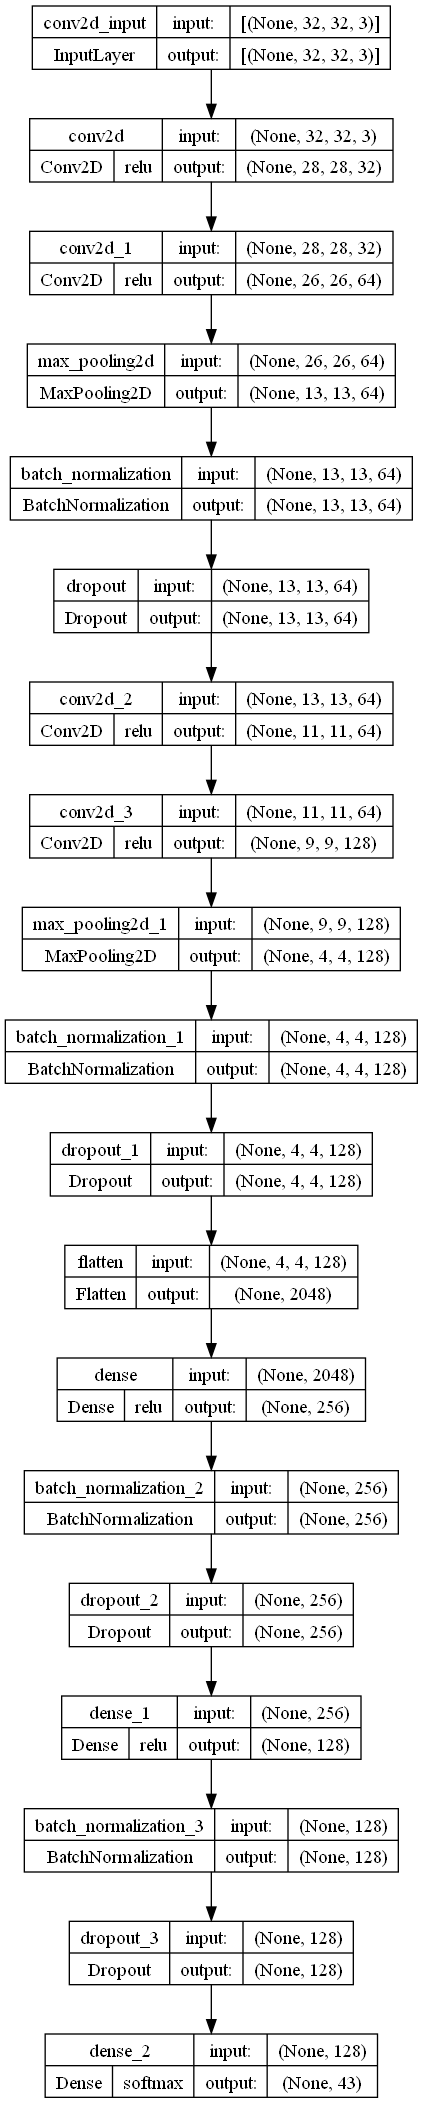

In [20]:
plot_model(model, "MA_thesis_classifier.png", show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [21]:
epochs = 30
batch_size = 64

opt_adam = Adam(lr = 0.001, decay = 0.001 / (epochs * 0.5))

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
#Compiling model
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = opt_adam, 
    metrics = ['accuracy', 'mse']
)

In [23]:
# Training model
# model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/30
613/613 [==============================] - 73s 116ms/step - loss: 0.8441 - accuracy: 0.7841 - mse: 0.0067
Epoch 2/30
613/613 [==============================] - 86s 141ms/step - loss: 0.1006 - accuracy: 0.9742 - mse: 9.6804e-04
Epoch 3/30
613/613 [==============================] - 97s 158ms/step - loss: 0.0599 - accuracy: 0.9832 - mse: 5.9660e-04
Epoch 4/30
613/613 [==============================] - 69s 112ms/step - loss: 0.0426 - accuracy: 0.9878 - mse: 4.3500e-04
Epoch 5/30
613/613 [==============================] - 67s 109ms/step - loss: 0.0325 - accuracy: 0.9905 - mse: 3.3934e-04
Epoch 6/30
613/613 [==============================] - 67s 109ms/step - loss: 0.0287 - accuracy: 0.9920 - mse: 2.9984e-04
Epoch 7/30
613/613 [==============================] - 68s 111ms/step - loss: 0.0234 - accuracy: 0.9932 - mse: 2.4979e-04
Epoch 8/30
613/613 [==============================] - 74s 120ms/step - loss: 0.0236 - accuracy: 0.9928 - mse: 2.5410e-04
Epoch 9/30
613/613 [================

In [24]:
# Predicting on test data
y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
accuracy_score(np.array(testLabels), y_predict)

395/395 [==============================] - 6s 14ms/step


0.9877276326207443

# Model with augmentations

In [25]:
# Applying augmentation methods to train data # TO DO
dataaug = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    rotation_range = 15,
    zoom_range = 0.10,
    fill_mode = "nearest")

(32, 3)
(32, 3)
(32, 3)
(32, 3)
(32, 3)
(32, 3)


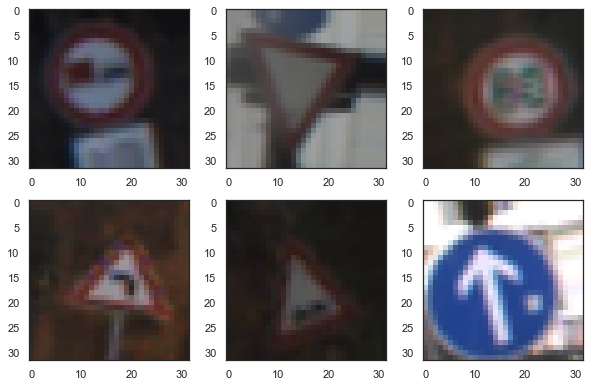

In [113]:
# Visualizing some augmented images

# Setting size of figure
plt.figure(figsize=(10,10))

# Setting up seed for replicability
random.seed(1)

# Loop for creating figure with images
for i in range(1,7):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Getting random image and augmenting it
    aug_iter = dataaug.flow(X_train, batch_size=1)
    image_aug = next(aug_iter)[0].astype('uint8')
    # Plotting images
    plt.imshow(image_aug)

# Saving image to jpg
#plt.savefig('Images_augmented.jpg', bbox_inches='tight')

In [26]:
# Training model
# pre_model_history = model.fit(dataaug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, 
#                               validation_data = (X_test, y_test),
#                               callbacks = [ModelCheckpoint('MA_thesis_classifier.h5', save_best_only=True)]
#                               )

Epoch 1/30
613/613 [==============================] - 79s 128ms/step - loss: 0.3363 - accuracy: 0.9179 - mse: 0.0029 - val_loss: 0.0375 - val_accuracy: 0.9904 - val_mse: 3.5170e-04
Epoch 2/30
613/613 [==============================] - 79s 129ms/step - loss: 0.1351 - accuracy: 0.9607 - mse: 0.0014 - val_loss: 0.0334 - val_accuracy: 0.9895 - val_mse: 3.6404e-04
Epoch 3/30
613/613 [==============================] - 78s 127ms/step - loss: 0.1001 - accuracy: 0.9702 - mse: 0.0010 - val_loss: 0.0416 - val_accuracy: 0.9892 - val_mse: 3.8033e-04
Epoch 4/30
613/613 [==============================] - 77s 126ms/step - loss: 0.0716 - accuracy: 0.9782 - mse: 7.6735e-04 - val_loss: 0.0481 - val_accuracy: 0.9866 - val_mse: 4.7584e-04
Epoch 5/30
613/613 [==============================] - 81s 132ms/step - loss: 0.0673 - accuracy: 0.9804 - mse: 6.9676e-04 - val_loss: 0.0377 - val_accuracy: 0.9888 - val_mse: 3.9193e-04
Epoch 6/30
613/613 [==============================] - 83s 135ms/step - loss: 0.0558 - a

In [29]:
# Saving model
# model.save('MA_thesis_classifier.h5')

In [16]:
# Loading model
model = keras.models.load_model('MA_thesis_classifier.h5')

In [17]:
# Predicting on test data
pre_y_predict = np.argmax(model.predict(X_test), axis=1)

# Checking accuracy on test data
accuracy_score(np.array(testLabels), pre_y_predict)

395/395 [==============================] - 6s 13ms/step


0.9902612826603325

In [18]:
# Creating detailed classification report
print(classification_report(testLabels.tolist(), pre_y_predict.tolist()))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.98      1.00      0.99       720
           2       1.00      0.99      1.00       750
           3       1.00      0.98      0.99       450
           4       1.00      0.97      0.99       660
           5       0.98      1.00      0.99       630
           6       0.99      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.98      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [143]:
# Saving classification report to csv
report = classification_report(testLabels.tolist(), pre_y_predict.tolist(), output_dict=True)
classification_results= pd.DataFrame(report).transpose()
#classification_results.to_csv('classification_report.csv')

# Plotting results


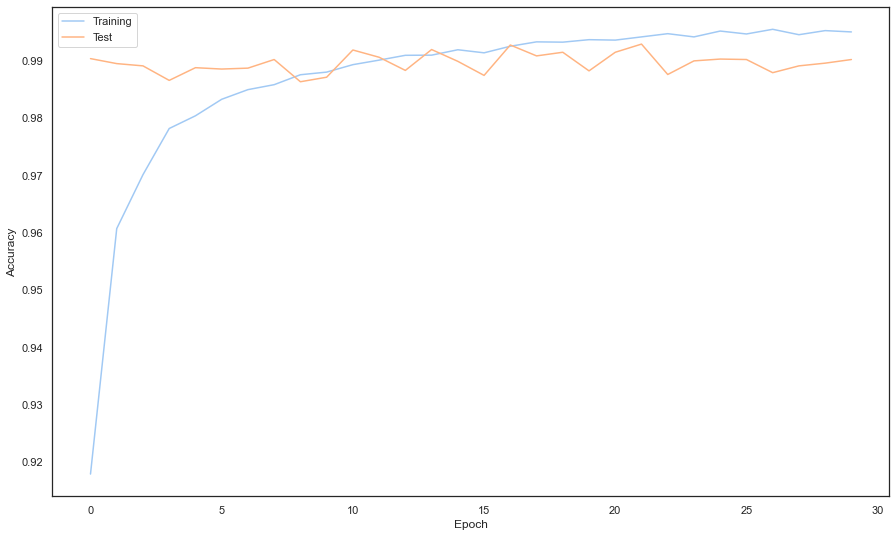

In [30]:
# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(pre_model_history.history['accuracy'])
plt.plot(pre_model_history.history['val_accuracy'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

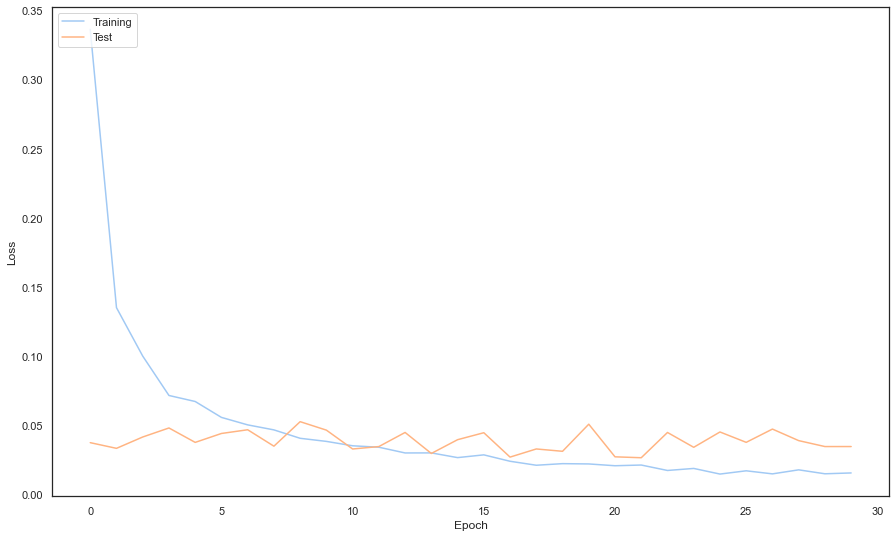

In [31]:
# Setting up size of plot and theme
sns.set_theme(style="white", palette="pastel")
plt.figure(figsize=(15,9))

# Plotting accuracy
plt.plot(pre_model_history.history['loss'])
plt.plot(pre_model_history.history['val_loss'])

# Setting up labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# and legend
plt.legend(['Training', 'Test'], loc='upper left')

plt.show()

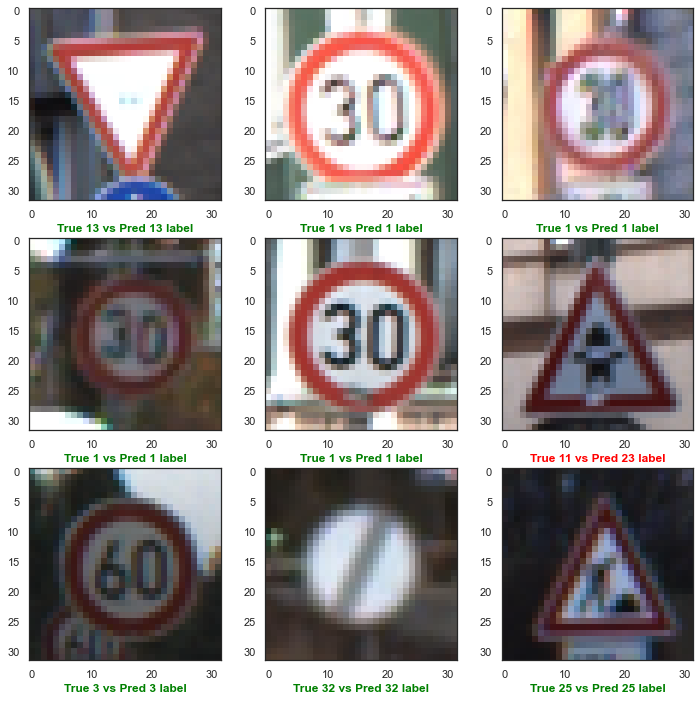

In [131]:
# Visualizing predicted labels vs true labels

# Setting size of figure
plt.figure(figsize=(12,12))

# Setting up seed for replicability
random.seed(16)

# Loop for creating figure with images
for i in range(1,10):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Choosing random number
    number = random.randint(0,12630)

    # Getting random image and coresponding label + predicted label
    image = X_test[number]
    pred_label = pre_y_predict[number]
    true_label = testLabels[number]

    # If labels dont match, display red color
    if pred_label == true_label:
            x = 'green'
    else:
            x = 'red'

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel("True {} vs Pred {} label".format(true_label, pred_label), 
               fontweight='bold',
               color = x)

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

In [21]:
# Getting only misclassified images and their labels

# Preparing lists
misclassified_images = []
misclassified_labels = []
right_labels = []

# Loop for getting wrong labels and corresponding images
for i in range(len(pre_y_predict)) :
  if pre_y_predict[i] != testLabels[i] :
    misclassified_images.append(testImages[i])
    misclassified_labels.append(pre_y_predict[i])
    right_labels.append(testLabels[i])

print("{}/{} images are misclassified. That is around {:.2f}% of all images".format(len(misclassified_labels), testLabels.shape[0], len(misclassified_labels)/testLabels.shape[0]*100))

123/12630 images are misclassified. That is around 0.97% of all images


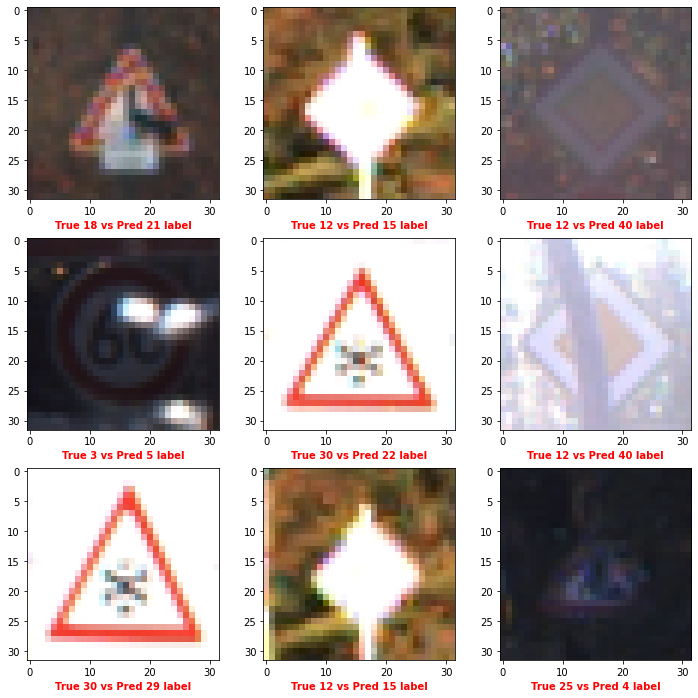

In [39]:
# Visualizing misclassified images

# Setting size of figure
plt.figure(figsize=(12,12))

# Setting up seed for replicability
random.seed(2)

# Loop for creating figure with images
for i in range(1,10):
    
    # Creating subplots for 10 images
    plt.subplot(3,3,i)

    # Choosing random number
    number = random.randint(0,123)

    # Getting random image and coresponding label + predicted label
    image = misclassified_images[number]
    pred_label = misclassified_labels[number]
    true_label = right_labels[number]

    # If labels dont match, display red color
    if pred_label == true_label:
            x = 'green'
    else:
            x = 'red'

    # Plotting images and labels
    plt.imshow(image)
    plt.xlabel("True {} vs Pred {} label".format(true_label, pred_label), 
               fontweight='bold',
               color = x)

# Saving image to jpg
#plt.savefig('Images_vis.jpg', bbox_inches='tight')

In [119]:
# Count missclassified images for each label 
count_classes = Counter(misclassified_labels)
count_classes.most_common()

[(1, 18),
 (23, 12),
 (26, 10),
 (5, 10),
 (0, 8),
 (11, 6),
 (30, 5),
 (29, 5),
 (40, 5),
 (15, 5),
 (27, 4),
 (25, 4),
 (22, 4),
 (20, 3),
 (9, 3),
 (21, 3),
 (35, 3),
 (36, 2),
 (3, 2),
 (2, 2),
 (13, 2),
 (18, 1),
 (37, 1),
 (6, 1),
 (8, 1),
 (32, 1),
 (4, 1),
 (28, 1)]

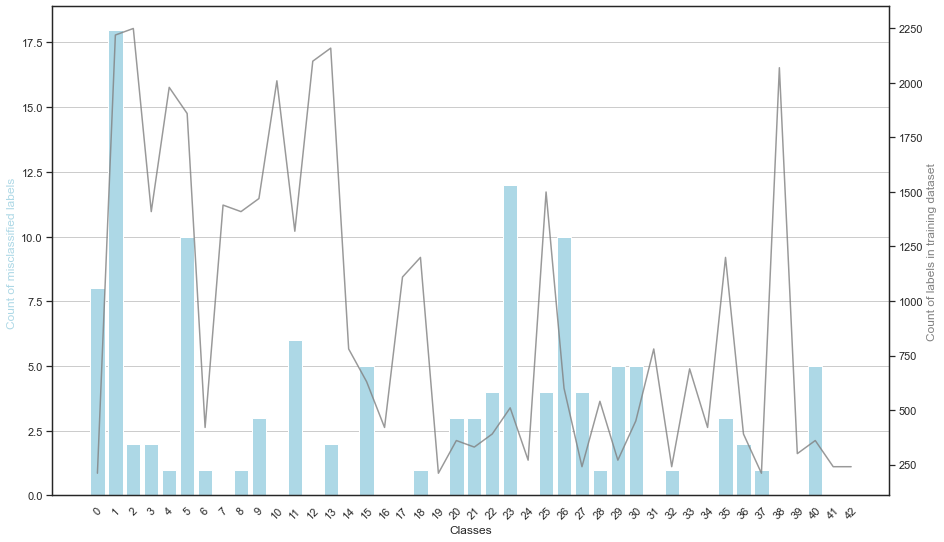

In [122]:
# Comparison of 

# Setting up theme and grid look
plt.figure(figsize=(15,9))
plt.grid(axis='y')

# Plotting count of misclassified labels 
plt.bar(count_classes.keys(), count_classes.values(), color='lightblue')

# adding labels and legend
plt.ylabel('Count of misclassified labels ', color='lightblue')
plt.xlabel('Classes')
plt.xticks(unique_classes_train, rotation=45)

# Adding second y axis
plt.twinx()

# Plotting count of labels in training dataset
plt.plot(unique_classes_train,classes_counts_train, color='grey', alpha=0.8)
plt.ylabel('Count of labels in training dataset', color='grey')

plt.show()

# TO DO:
- fix miclassified images 
- plot distribution of misclassified image